In [1]:
import sys
from pathlib import Path

from astropy import table
from astropy.io import fits
import numpy as np
from tqdm import tqdm
from matplotlib import colors, gridspec
from matplotlib import pyplot as plt
import cmocean
import betterplotlib as bpl

bpl.set_style()

In [2]:
# catalog_paths = []
# data_dir = Path("../data/").resolve()
# for cluster_dir in data_dir.iterdir():
#     if cluster_dir.is_dir():
#         cat = cluster_dir / "size" / "cluster_fits_30_pixels_psf_my_stars_15_pixels_2x_oversampled.h5"
#         if cat.exists():
#             catalog_paths.append(cat)
            
# catalogs = [table.Table.read(str(c), format="hdf5") for c in catalog_paths]
# catalog = table.vstack(catalogs, join_type="inner")

In [3]:
catalog = table.Table.read("../data/ngc1313-e/size/cluster_fits_no_masking_size_30_pixels_psf_my_stars_15_pixels_2x_oversampled.h5", format="hdf5")

In [4]:
def unpad(padded_array):
    return padded_array[np.where(~np.isnan(padded_array))]


def pad(array, total_length):
    final_array = np.zeros(total_length) * np.nan
    final_array[: len(array)] = array
    return final_array


dist_cols = [
    "x_fitted",
    "y_fitted",
    "x_pix_snapshot_oversampled",
    "y_pix_snapshot_oversampled",
    "central_surface_brightness",
    "scale_radius_pixels",
    "axis_ratio",
    "position_angle",
    "power_law_slope",
    "local_background",
]
for col in dist_cols:
    catalog[col] = [unpad(row[col]) for row in catalog]


# Create columns with postprocessed data

In [5]:
def postprocess_params(log_mu_0, x_c, y_c, a, q, theta, eta, background):
    """
    Postprocess the parameters, namely the axis ratio and position angle.

    This is needed since we let the fit have axis ratios larger than 1, and position
    angles of any value. Axis ratios larger than 1 indicate that we need to flip the
    major and minor axes. This requires rotating the position angle 90 degrees, and
    shifting the value assigned to the major axis to correct for the improper axis
    ratio.
    """
    # q and a can be negative, fix that before any further processing
    a = abs(a)
    q = abs(q)
    if q > 1.0:
        q_final = 1.0 / q
        a_final = a * q
        theta_final = (theta - (np.pi / 2.0)) % np.pi
        return [log_mu_0, x_c, y_c, a_final, q_final, theta_final, eta, background]
    else:
        return [log_mu_0, x_c, y_c, a, q, theta % np.pi, eta, background]

In [6]:
columns_compare = [
    "central_surface_brightness",
    "x_pix_snapshot_oversampled",
    "y_pix_snapshot_oversampled",
    "scale_radius_pixels",
    "axis_ratio",
    "position_angle",
    "power_law_slope",
    "local_background",
]

def get_params(row, idx, style):
    if style == "raw":
        postfix = ""
    else:
        postfix = "_post"
    return [row[col+postfix][idx] for col in columns_compare]

In [7]:
for col in columns_compare:
    catalog[f"{col}_post"] = catalog[col] * np.nan
    
for row in catalog:
    new_entries = {col:[] for col in columns_compare}
    for idx in range(7):
        params = get_params(row, idx, "raw")
        post_params = postprocess_params(*params)
        # distribute these values into their appropriate columns
        for param_idx, col in enumerate(columns_compare):
            new_entries[col].append(post_params[param_idx])
    
    # then set these values as the ones for the row
    for col in new_entries:
        row[f"{col}_post"] = new_entries[col]

# Histogram of how many unique values there are

In [16]:
def x_y_disagreement(x1, x2):
    # X center - must be within 0.5 pixels
    return not np.isclose(x1, x2, rtol=0, atol=0.5)

def peak_disagreement(mu1, mu2):
    # peak brightness - must be within 5%
    return not np.isclose(mu1, mu2, rtol=0.05, atol=0)

def a_disagreement(a1, a2):
    # scale radius - must be within 5%
    return not np.isclose(a1, a2, rtol=0.05, atol=0)

def q_disagreement(q1, q2):
    # axis ratio - must be within 0.05
    return not np.isclose(q1, q2, rtol=0, atol=0.05)

def theta_disagreement(theta1, theta2):
    # position angle - must be within 5 degrees
    tolerance = 5 * np.pi / 180
    
    # Always postprocess
    theta1 = theta1 % np.pi
    theta2 = theta2 % np.pi
    
    if not np.isclose(theta1, theta2, rtol=0, atol=tolerance):
        # otherwise, we might have a mismatch due to the value being on either side
        # of the boundary, pi. Subtract pi from the larger value and check again
        if theta1 > theta2:
            theta1 -= np.pi
        else:
            theta2 -= np.pi
        return not np.isclose(theta1, theta2, rtol=0, atol=tolerance)
    else:  # it was close, no disagreement
        return False
    
def eta_disagreement(eta1, eta2):
    # power law slope, must be within 5%
    return not np.isclose(eta1, eta2, rtol=0.05)

def background_disagreement(bg1, bg2):
    # local background, must be within 5 or 5%
    return not np.isclose(bg1, bg2, rtol=0.05, atol=5)

param_disagreement_funcs = {
    "x_pix_snapshot_oversampled": x_y_disagreement,
    "y_pix_snapshot_oversampled": x_y_disagreement,
    "central_surface_brightness": peak_disagreement,
    "scale_radius_pixels": a_disagreement,
    "axis_ratio": q_disagreement,
    "position_angle": theta_disagreement,
    "power_law_slope": eta_disagreement,
    "local_background": background_disagreement,  
}
    
def get_mismatches(params_1, params_2):
    # turn params into lists for processing later
    params_1 = list(params_1)
    params_2 = list(params_2)
    
    mismatches = []    
    
    if peak_disagreement(params_1[0], params_2[0]):
        mismatches.append("central_surface_brightness")
    
    if x_y_disagreement(params_1[1], params_2[1]):
        mismatches.append("x_pix_snapshot_oversampled")
    
    if x_y_disagreement(params_1[2], params_2[2]):
        mismatches.append("y_pix_snapshot_oversampled")
    
    if a_disagreement(params_1[3], params_2[3]):
        mismatches.append("scale_radius_pixels")
    
    if q_disagreement(params_1[4], params_2[4]):
        mismatches.append("axis_ratio")
    
#     if theta_disagreement(params_1[5], params_2[5]):
#         mismatches.append("position_angle")
        
    if eta_disagreement(params_1[6], params_2[6]):
        mismatches.append("power_law_slope") 
        
    # local background, must be within 1 or 1%
    if background_disagreement(params_1[7], params_2[7]):
        mismatches.append("local_background") 
    
    # give back what was incorrect
    return mismatches

# Determining how many fits agreed with the most common one

In [17]:
catalog['unique_params_raw'] = 0
catalog['unique_params_post'] = 0
catalog["max_agreements_post"] = 0
catalog["max_agreements_raw"] = 0

for row in tqdm(catalog):
    for style in ["raw", "post"]:
        # start our list of unique parameters sets by getting the first one. Set this up as 
        # a dictionary where it holds the number of times a cluster agreed with that one
        unique_params = {tuple(get_params(row, 0, style)): 0}

        # then compare the rest to get the set of unique values.
        for idx in range(7):
            this_params = get_params(row, idx, style)

            # iterate through all the current unique values to compare to this. We start by
            # assuming it is unique. If we find a match we know it is not unique
            is_unique = True
            for unique_set in unique_params:
                if 0 == len(get_mismatches(unique_set, this_params)):
                    is_unique = False
                    unique_params[unique_set] += 1

            if style == "post":
                this_params = postprocess_params(*this_params)
            if is_unique:
                unique_params[tuple(this_params)] = 1

        row[f"unique_params_{style}"] = len(unique_params)
        row[f"max_agreements_{style}"] = max(unique_params.values())

100%|██████████| 137/137 [00:00<00:00, 158.19it/s]


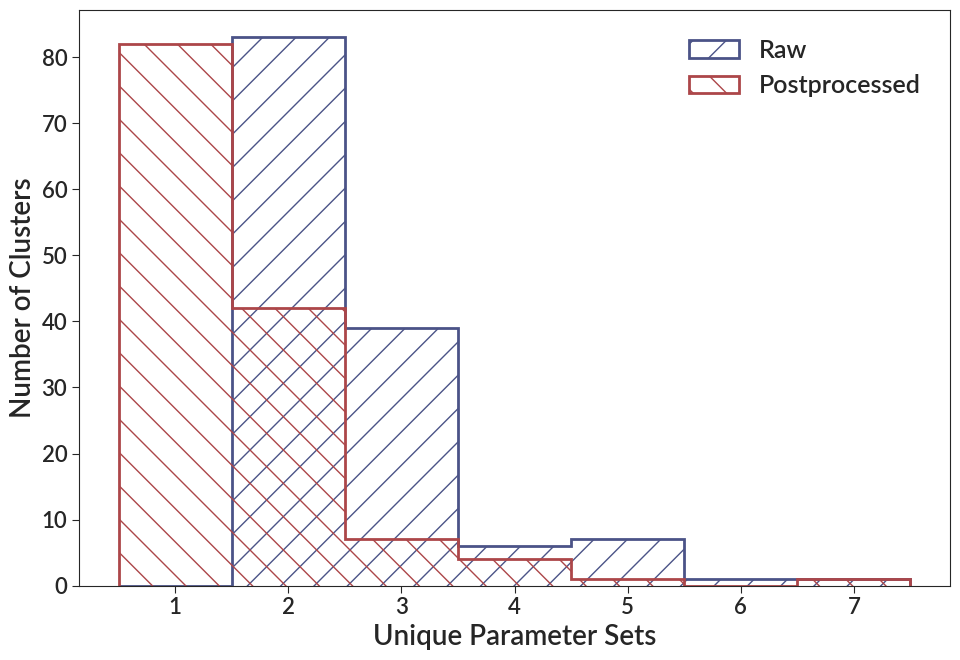

In [18]:
fig, ax = bpl.subplots()
bins = np.arange(0.5, 8.5, 1.0)
ax.hist(catalog["unique_params_raw"], bins=bins, histtype="step", lw=2, hatch="/", label='Raw')
ax.hist(catalog["unique_params_post"], bins=bins, histtype="step", lw=2, hatch="\\", label='Postprocessed', color=bpl.color_cycle[3])
ax.legend()
ax.add_labels("Unique Parameter Sets", "Number of Clusters")

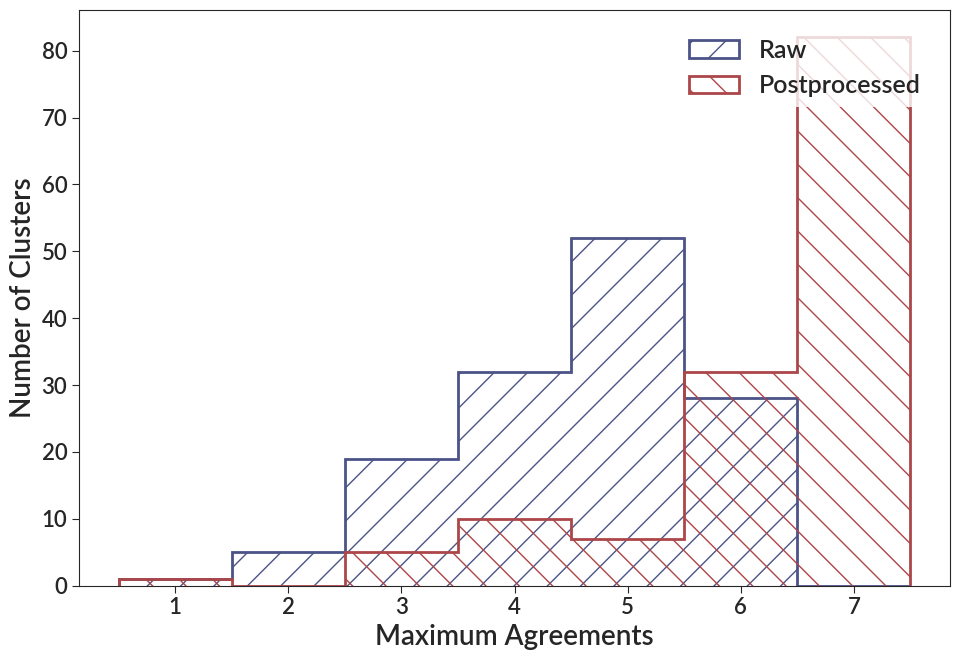

In [19]:
fig, ax = bpl.subplots()
bins = np.arange(0.5, 8.5, 1.0)
ax.hist(catalog["max_agreements_raw"], bins=bins, histtype="step", lw=2, hatch="/", label='Raw')
ax.hist(catalog["max_agreements_post"], bins=bins, histtype="step", lw=2, hatch="\\", label='Postprocessed', color=bpl.color_cycle[3])
ax.legend()
ax.add_labels("Maximum Agreements", "Number of Clusters")

# Determining which parameters were in disagreement when disagreements happened

In [20]:
for col in columns_compare:
    for style in ["raw", "post"]:
        catalog[f"unique_values_{col}_{style}"] = 0
        catalog[f"max_agreements_{col}_{style}"] = 0

for row in tqdm(catalog):
    for style in ["raw", "post"]:
        # count up the number of unique values for each parameter independently
        for col in columns_compare:            
            if style == "post":
                these_values = row[col + "_post"]
            else:
                these_values = row[col]

            # start our list of unique values
            unique_values = {these_values[0]: 0}
            # iterate through all the current unique values to compare to this. We start by
            # assuming it is unique. If we find a match we know it is not unique
            for value in these_values:
                is_unique = True
                for unique_value in unique_values:
                    # if we have agreement, increase the number that agree and mark that
                    # this is not unique
                    if not param_disagreement_funcs[col](value, unique_value):
                        unique_values[unique_value] += 1
                        is_unique = False
                        
                if is_unique:
                    unique_values[value] = 1
            
            # then store the values for this column
            row[f"unique_values_{col}_{style}"] = len(unique_values)
            row[f"max_agreements_{col}_{style}"] = max(unique_values.values())

100%|██████████| 137/137 [00:00<00:00, 142.80it/s]


[85 44  4  3  0  1  0]
[122  12   3   0   0   0   0]
[124  11   2   0   0   0   0]
[85 43  6  1  1  0  1]
[112  20   4   1   0   0   0]
[110  21   4   1   1   0   0]
[82 49  4  2  0  0  0]
[85 48  4  0  0  0  0]


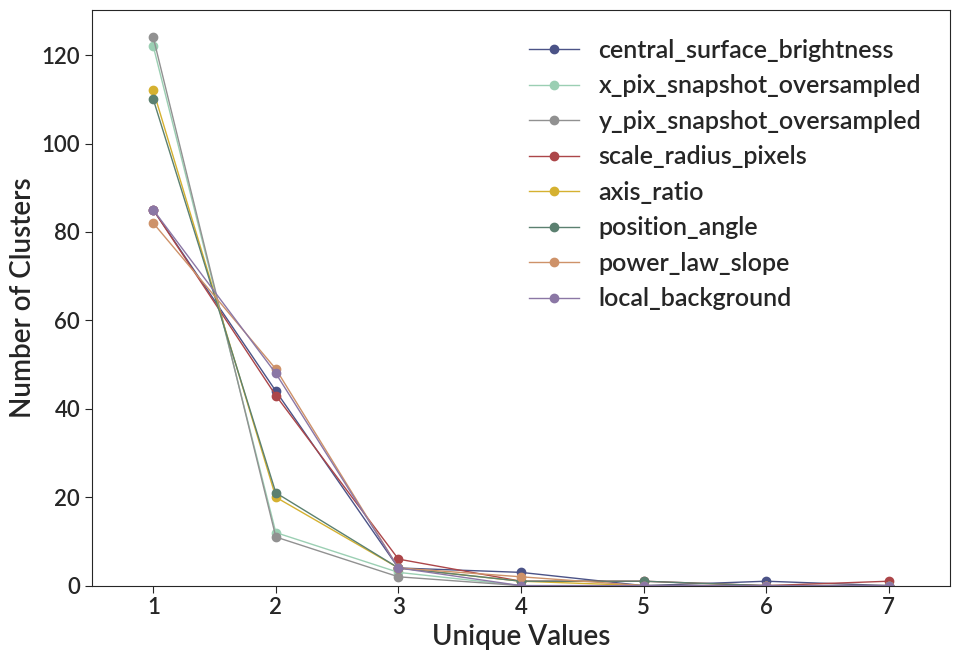

In [21]:
fig, ax = bpl.subplots()
bins = np.arange(0.5, 8.5, 1.0)
centers = [1, 2, 3, 4, 5, 6, 7]
for col in columns_compare:
    hist, edges = np.histogram(catalog[f"unique_values_{col}_post"], bins=bins)
    print(hist)
    ax.plot(centers, hist, marker='o', lw=1, label=col)
ax.legend()
ax.set_limits(0.5, 7.5, 0)
# ax.set_yscale("log")
ax.add_labels("Unique Values", "Number of Clusters")

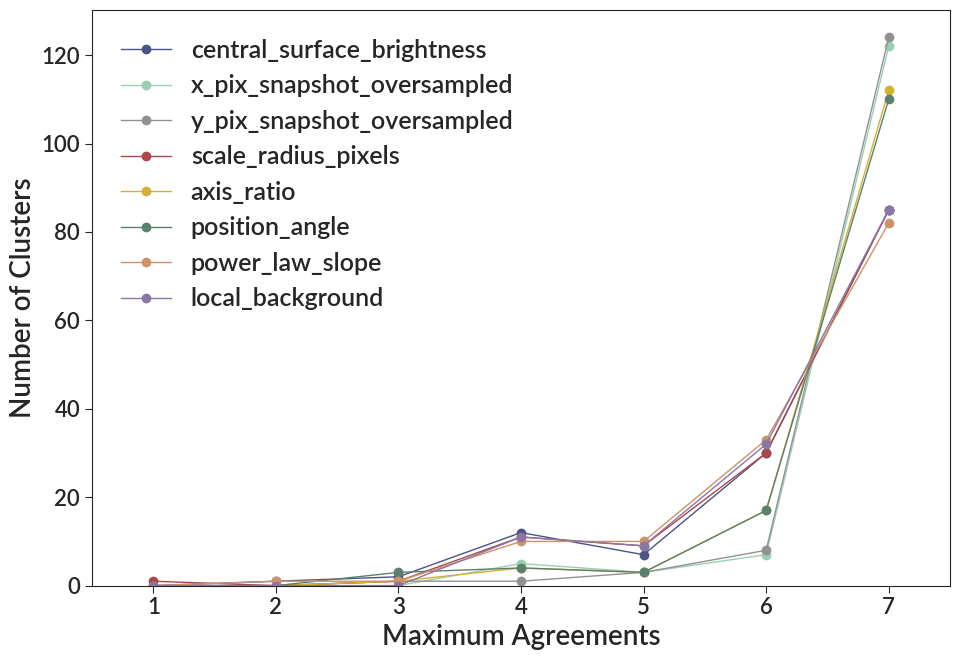

In [22]:
fig, ax = bpl.subplots()
bins = np.arange(0.5, 8.5, 1.0)
centers = [1, 2, 3, 4, 5, 6, 7]
for col in columns_compare:
    hist, edges = np.histogram(catalog[f"max_agreements_{col}_post"], bins=bins)
    ax.plot(centers, hist, marker='o', lw=1, label=col)
ax.legend()
ax.set_limits(0.5, 7.5, 0)
ax.add_labels("Maximum Agreements", "Number of Clusters")

# Figure out which starting point disagreed the most

In [23]:
for style in ["raw", "post"]:
    for point in range(7):
        catalog[f"with_majority_{point}_{style}"] = False

for row in tqdm(catalog):
    for style in ["raw", "post"]:
        # count up the unique values in the exact same way we did before
        # start our list of unique parameters sets by getting the first one. Set this up as 
        # a dictionary where it holds the number of times a cluster agreed with that one
        unique_params = {tuple(get_params(row, 0, style)): 0}

        # then compare the rest to get the set of unique values.
        for idx in range(7):
            this_params = get_params(row, idx, style)

            # iterate through all the current unique values to compare to this. We start by
            # assuming it is unique. If we find a match we know it is not unique
            is_unique = True
            for unique_set in unique_params:
                if 0 == len(get_mismatches(unique_set, this_params)):
                    is_unique = False
                    unique_params[unique_set] += 1

            if style == "post":
                this_params = postprocess_params(*this_params)
            if is_unique:
                unique_params[tuple(this_params)] = 1
        
        
        # Then we can determine which is the unique value with the highest number of
        # matches
        max_agreements = 0
        best_params = None
        for unique_set in unique_params:
            if unique_params[unique_set] > max_agreements:
                max_agreements = unique_params[unique_set]
                best_params = unique_set
        # then determine whether the given starting point agrees with this best value
        for idx in range(7):
            this_params = get_params(row, idx, style)
            mismatches = get_mismatches(this_params, best_params)
            row[f"with_majority_{idx}_{style}"] = len(mismatches) == 0

100%|██████████| 137/137 [00:01<00:00, 93.61it/s]


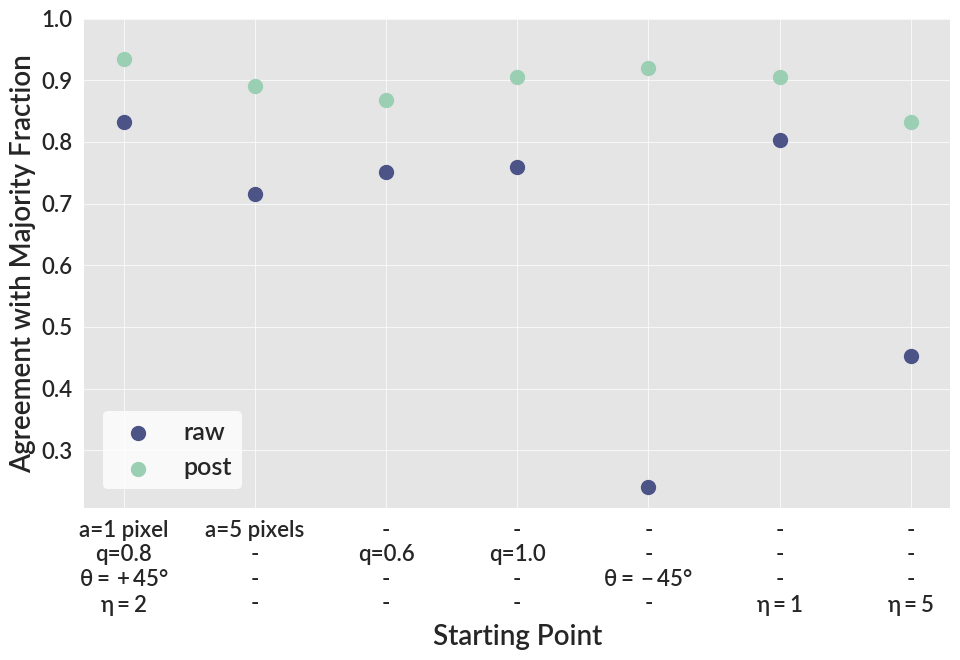

In [24]:
fig, ax = bpl.subplots()
ax.make_ax_dark()
for style in ["raw", "post"]:
    xs = []
    ys = []
    for point in range(7):
        agreements = catalog[f"with_majority_{point}_{style}"]
        fraction = np.sum(agreements) / len(agreements)
        xs.append(point)
        ys.append(fraction)

    ax.scatter(xs, ys, s=100, label=style)
ax.set_limits(y_max=1)
ax.legend(loc=3)
ax.xaxis.set_ticks(range(7))
ax.xaxis.set_ticklabels(["a=1 pixel\nq=0.8\n$\\theta = +45 \degree$\n$\eta=2$",
                         "a=5 pixels\n-\n-\n-",
                         "-\nq=0.6\n-\n-",
                         "-\nq=1.0\n-\n-",
                         "-\n-\n$\\theta = -45 \degree$\n-",
                         "-\n-\n-\n$\eta=1$",
                         "-\n-\n-\n$\eta=5$"])
ax.add_labels("Starting Point", 'Agreement with Majority Fraction')

# Plot where the disagreements were in different planes

In [25]:
names = {
    0:"central_surface_brightness_best",
    1: "x_pix_snapshot_oversampled_best",
    2: "y_pix_snapshot_oversampled_best",
    3: "scale_radius_pixels_best",
    4: "axis_ratio_best",
    5: "position_angle_best",
    6: "power_law_slope_best",
    7: "local_background_best", 
}

params = {
    "central_surface_brightness_best": "Central Surface Brightness [e$^-$]",
    "x_pix_snapshot_oversampled_best": "X Center",
    "y_pix_snapshot_oversampled_best": "Y Center",
    "scale_radius_pixels_best": "Scale Radius [pixels]",
    "axis_ratio_best": "Axis Ratio",
    "position_angle_best": "Position Angle",
    "power_law_slope_best": "$\eta$ (Power Law Slope)",
    "local_background_best": "Local Background [e$^-$]",
}
plot_params = ["scale_radius_pixels_best", "axis_ratio_best", "power_law_slope_best"]
param_limits = {
    "central_surface_brightness_best": (10, 1e8),
    "x_pix_snapshot_oversampled_best": (25, 35),
    "y_pix_snapshot_oversampled_best": (25, 35),
    "scale_radius_pixels_best": (0.01, 40),
    "axis_ratio_best": (-0.05, 1.05),
    "position_angle_best": (0, np.pi),
    "power_law_slope_best": (0, 3),
    "local_background_best": (-500, 1000),
}
param_scale = {
    "central_surface_brightness_best": "log",
    "x_pix_snapshot_oversampled_best": "linear",
    "y_pix_snapshot_oversampled_best": "linear",
    "scale_radius_pixels_best": "log",
    "axis_ratio_best": "linear",
    "position_angle_best": "linear",
    "power_law_slope_best": "linear",
    "local_background_best": "linear",
}
param_bins = {
    "central_surface_brightness_best": np.logspace(1, 8, 41),
    "x_pix_snapshot_oversampled_best": np.arange(25, 35, 0.25),
    "y_pix_snapshot_oversampled_best": np.arange(25, 35, 0.25),
    "scale_radius_pixels_best": np.logspace(-2, 1.4, 41),
    "axis_ratio_best": np.arange(-0.1, 1.1, 0.05),
    "position_angle_best": np.arange(0, 3.5, 0.1),
    "power_law_slope_best": np.arange(0, 3.2, 0.1),
    "local_background_best": np.arange(-300, 1500, 100),
}

In [26]:
import colorcet as cc

100%|██████████| 137/137 [00:07<00:00, 19.56it/s]


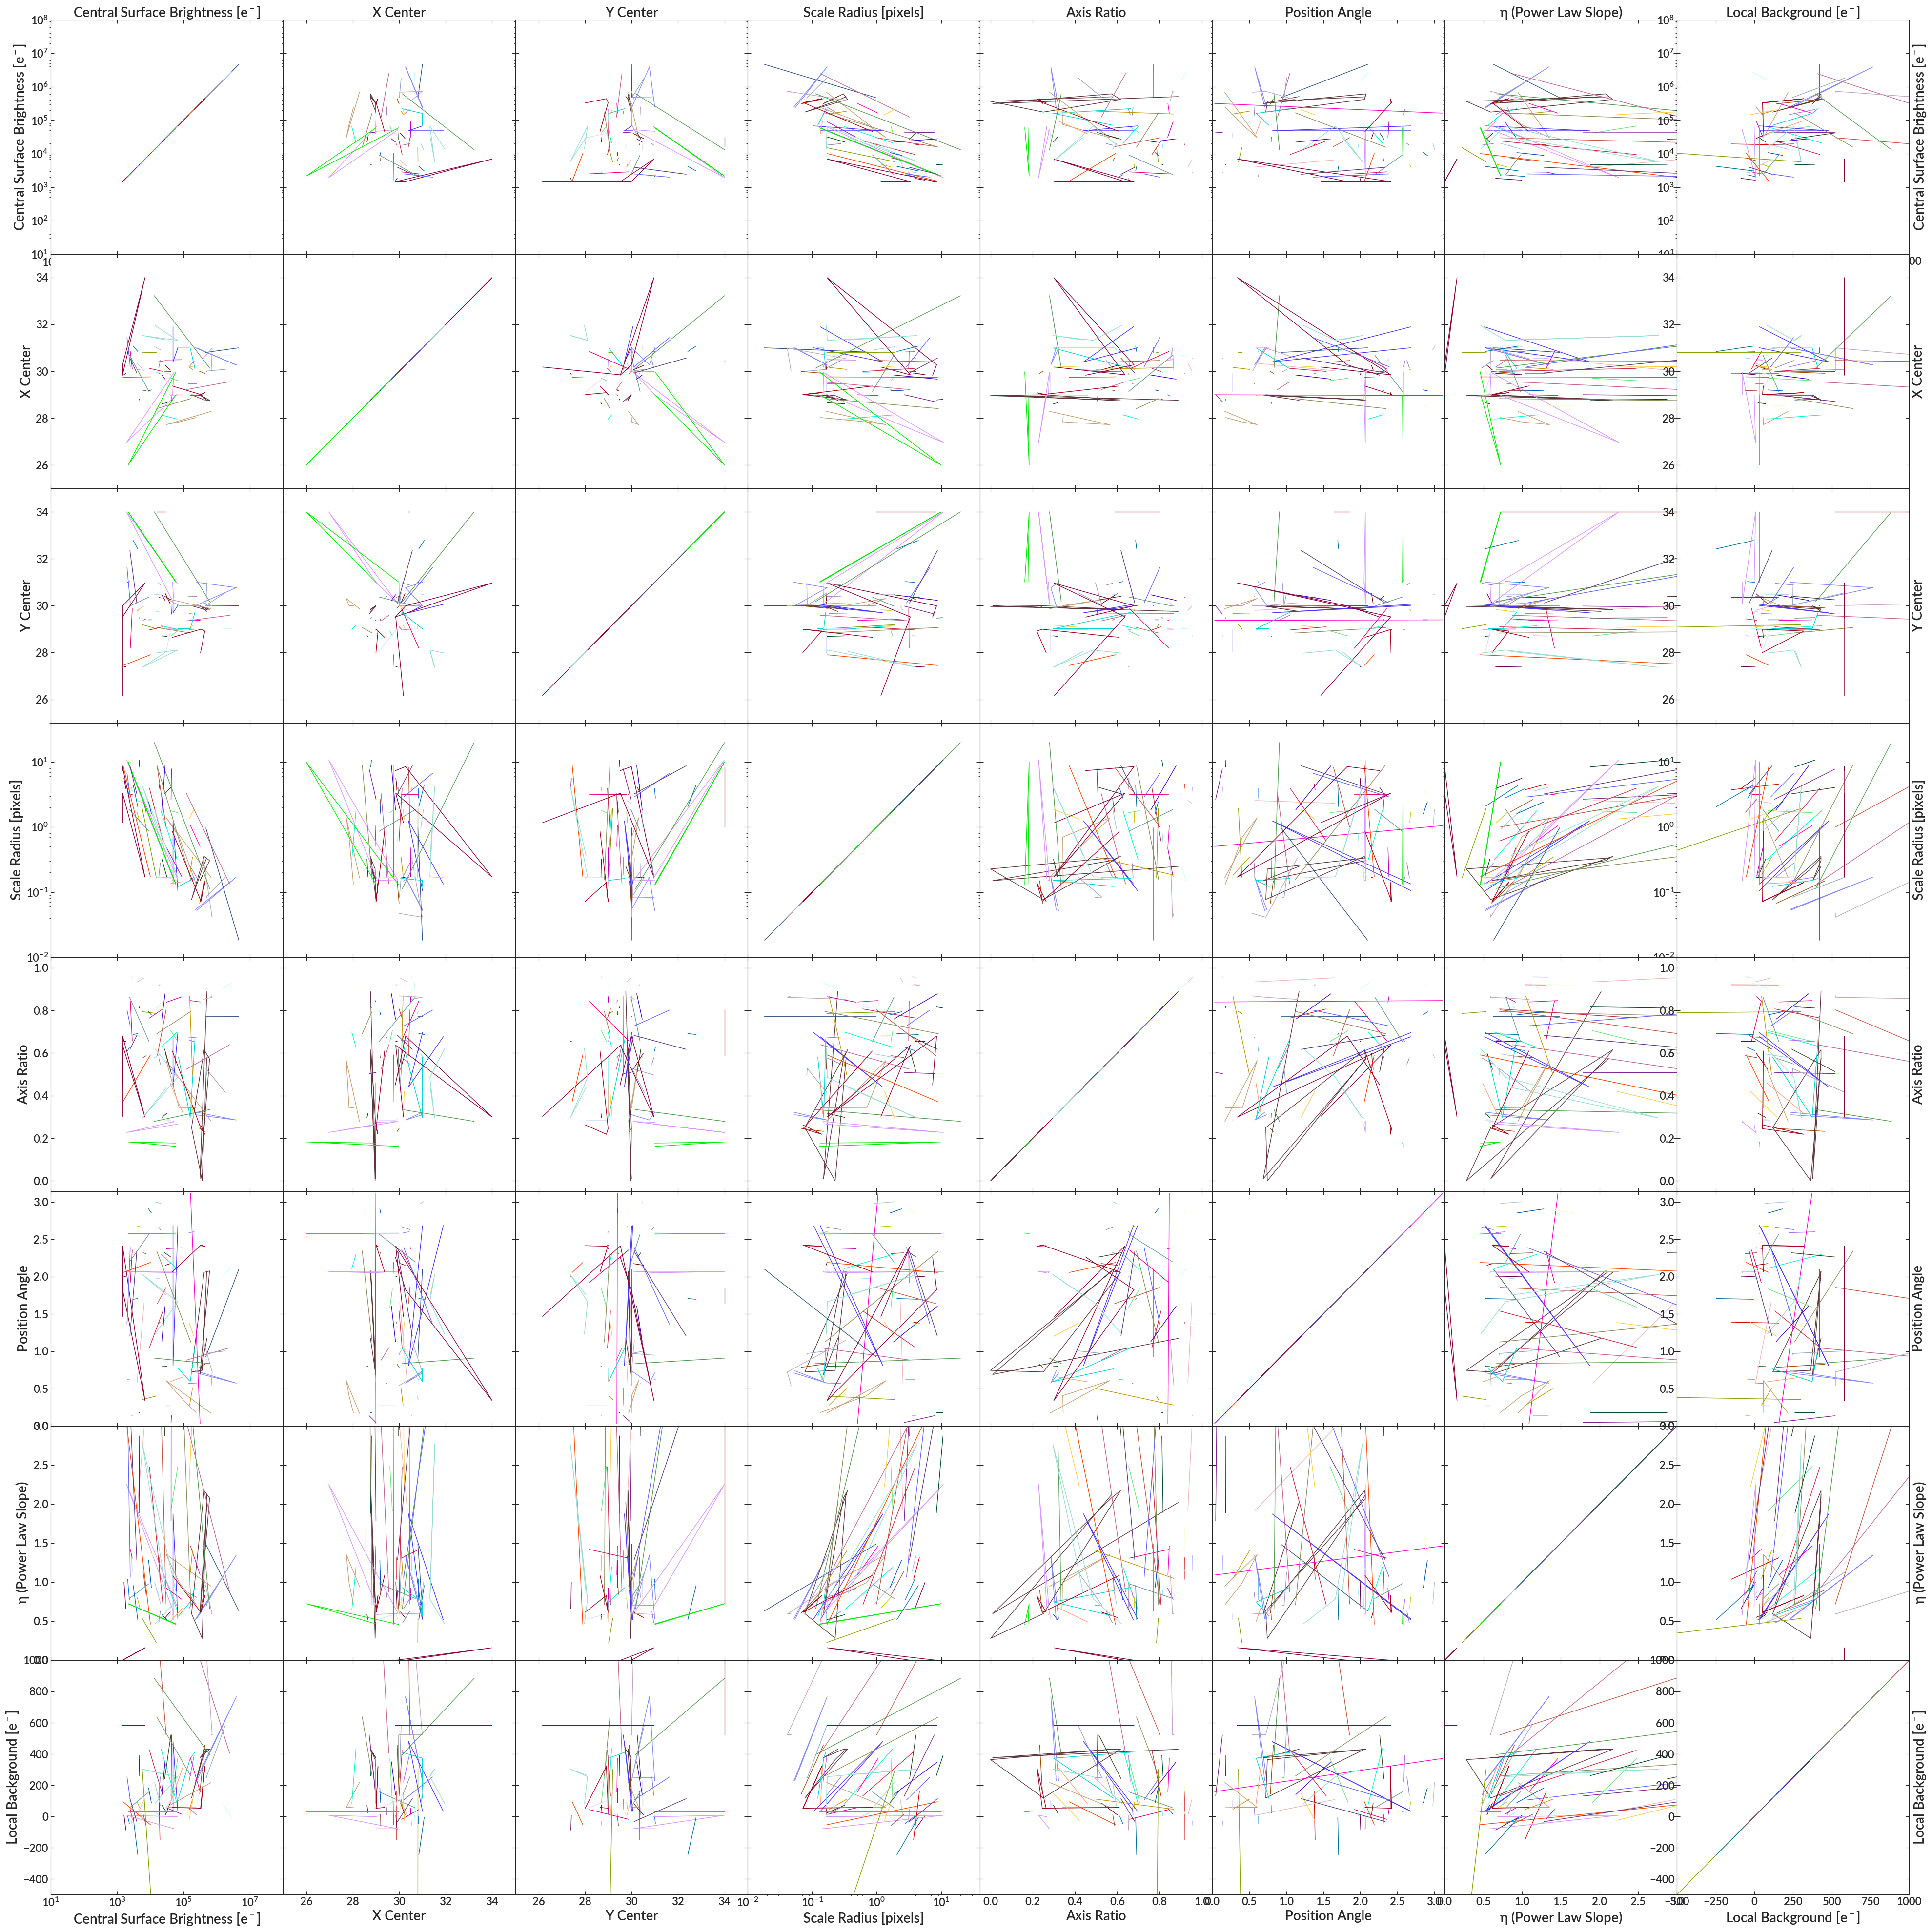

In [30]:
fig, axs = bpl.subplots(
    nrows=len(params),
    ncols=len(params),
    figsize=[5 * len(params), 5 * len(params)],
    sharex=False,
    sharey=False,
    gridspec_kw={"hspace": 0, "wspace": 0},
)

color_idx = 0
for row in tqdm(catalog):
    style = "post"

    # start our list of unique parameters sets by getting the first one. Set this up as 
    # a dictionary where it holds the number of times a cluster agreed with that one
    unique_params = {tuple(get_params(row, 0, style)): 0}

    # then compare the rest to get the set of unique values.
    for idx in range(7):
        this_params = get_params(row, idx, style)

        # iterate through all the current unique values to compare to this. We start by
        # assuming it is unique. If we find a match we know it is not unique
        is_unique = True
        for unique_set in unique_params:
            if 0 == len(get_mismatches(unique_set, this_params)):
                is_unique = False
                unique_params[unique_set] += 1

        if style == "post":
            this_params = postprocess_params(*this_params)
        if is_unique:
            unique_params[tuple(this_params)] = 1

    # Then plot all the unique values, attached by lines
    if len(unique_params) > 0:
        for idx_row in range(len(columns_compare)):
            for idx_col in range(len(columns_compare)):

                x_values = [values[idx_col] for values in unique_params]
                y_values = [values[idx_row] for values in unique_params]
                
                color = cc.glasbey[color_idx]

                axs[idx_row][idx_col].plot(x_values, y_values, lw=1, c=color)

        color_idx += 1
            
            
for idx_row, param_row in enumerate(params):
    for idx_col, param_col in enumerate(params):
        # get the axis at this location
        ax = axs[idx_row][idx_col]
        
        # set the limits
        ax.set_limits(*param_limits[param_col], *param_limits[param_row])
        ax.set_xscale(param_scale[param_col])
        ax.set_yscale(param_scale[param_row])
        
        # move all ticks to the inside
        ax.tick_params(axis="x", top=True, bottom=True, direction="in")
        ax.tick_params(axis="y", left=True, right=True, direction="in")
        # Then handle where the labels go. If we're in the left column, show the label
        if idx_col == 0:
            ax.add_labels(y_label=params[param_row])
        # put the labels on the right if we're on the last one
        elif idx_col == len(params) - 1:
            ax.add_labels(y_label=params[param_row])
            ax.yaxis.set_label_position("right")
        else:
            ax.yaxis.set_ticklabels([])

        # add the X label if we're in the bottom row
        if idx_row == len(params) - 1:
            ax.add_labels(x_label=params[param_col])
        elif idx_row == 0:  # put the label on top for the top row
            ax.add_labels(x_label=params[param_col])
            ax.xaxis.set_label_position("top")
        # if we're not on the bottom row, don't show the x labels
        else:
            ax.xaxis.set_ticklabels([])


fig.savefig("unique_corner.png", dpi=100)